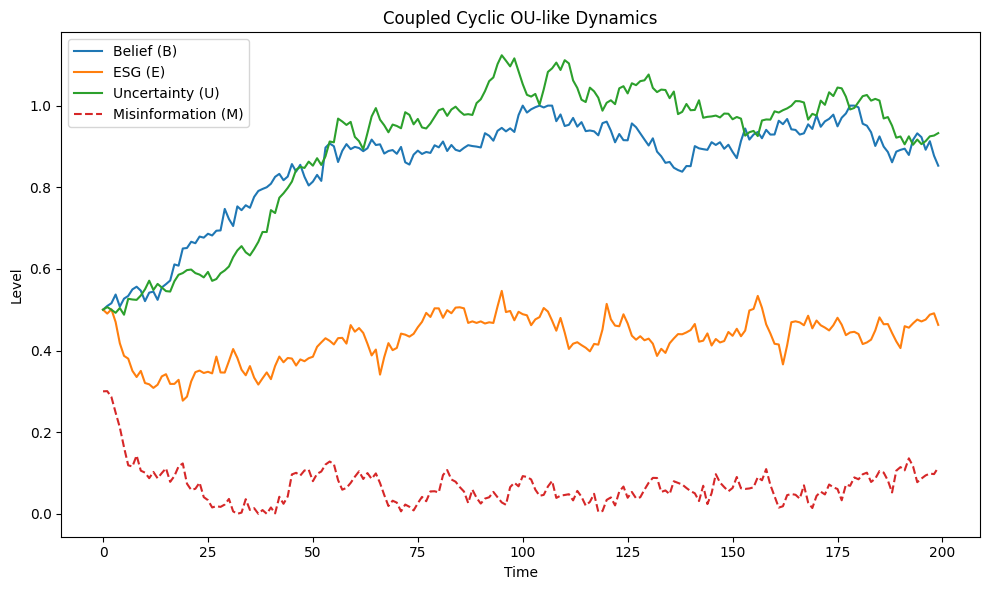

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
T = 200                 # time steps
dt = 1.0                # time increment
np.random.seed(42)

t = np.arange(T)
# Cyclic exogenous forcing common to all
X = 0.1 * np.sin(2 * np.pi * t / 40)

# Noise intensities
sigma_U = 0.02
sigma_B = 0.02
sigma_E = 0.02
sigma_M = 0.02

# Model constants
# Uncertainty U
A_U = 1.0; alpha = 0.5; beta_U = 1.2; delta_U = 0.3; eta_U = 0.4; k_U = 0.1
# Belief B
xi_B = 1.0; omega_B = 0.2; rho_B = 0.5; theta_E = 0.3; k_B = 0.1
# ESG E
rho_E = 0.5; delta_E = 0.6; varsigma = 0.3; phi_E = 0.05; k_E = 0.1
# Misinformation M
theta_U_M = 0.2; theta_B_M = 0.1; theta_E_M = 0.1; k_M = 0.1

# Initialize
B = np.zeros(T); U = np.zeros(T); E = np.zeros(T); M = np.zeros(T)
B[0]=U[0]=E[0]=0.5; M[0]=0.3

# Euler–Maruyama for coupled OU-like SDEs
for i in range(1, T):
    # compute targets
    target_U = A_U*(B[i-1]**beta_U) + delta_U*E[i-1] - eta_U*M[i-1] + X[i-1]
    target_B = xi_B*((U[i-1] - omega_B*M[i-1])/(1 + theta_E*E[i-1]))**rho_B
    target_E = rho_E*B[i-1]**delta_E*(1 - varsigma*M[i-1]) - phi_E*E[i-1]
    target_M = theta_U_M*U[i-1] - theta_B_M*B[i-1] - theta_E_M*E[i-1]

    # updates
    dU = k_U*(target_U - U[i-1])*dt + sigma_U*np.sqrt(dt)*np.random.randn()
    dB = k_B*(target_B - B[i-1])*dt + sigma_B*np.sqrt(dt)*np.random.randn()
    dE = k_E*(target_E - E[i-1])*dt + sigma_E*np.sqrt(dt)*np.random.randn()
    dM = k_M*(target_M - M[i-1])*dt + sigma_M*np.sqrt(dt)*np.random.randn()

    U[i] = max(U[i-1] + dU, 0)
    B[i] = np.clip(B[i-1] + dB, 0, 1)
    E[i] = max(E[i-1] + dE, 0)
    M[i] = np.clip(M[i-1] + dM, 0, 1)

# Plot
plt.figure(figsize=(10,6))
plt.plot(B, label='Belief (B)')
plt.plot(E, label='ESG (E)')
plt.plot(U, label='Uncertainty (U)')
plt.plot(M, '--', label='Misinformation (M)')
plt.title('Coupled Cyclic OU-like Dynamics')
plt.xlabel('Time')
plt.ylabel('Level')
plt.legend()
plt.tight_layout()
plt.show()


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
import shap

# ----------------------
# 1. SIMULATE THE SDE SYSTEM
# ----------------------
T = 200                 # time steps
dt = 1.0                # time increment
np.random.seed(42)

t = np.arange(T)
X_cycle = 0.1 * np.sin(2 * np.pi * t / 40)  # common exogenous forcing

# Noise intensities
sigma_U = sigma_B = sigma_E = sigma_M = 0.02

# Model constants
A_U, alpha, beta_U, delta_U, eta_U, k_U = 1.0, 0.5, 1.2, 0.3, 0.4, 0.1
xi_B, omega_B, rho_B, theta_E, k_B = 1.0, 0.2, 0.5, 0.3, 0.1
rho_E, delta_E, varsigma, phi_E, k_E = 0.5, 0.6, 0.3, 0.05, 0.1
theta_U_M, theta_B_M, theta_E_M, k_M = 0.2, 0.1, 0.1, 0.1

# Containers
B = np.zeros(T); U = np.zeros(T); E = np.zeros(T); M = np.zeros(T)
B[0] = U[0] = E[0] = 0.5; M[0] = 0.3

for i in range(1, T):
    target_U = A_U*(B[i-1]**beta_U) + delta_U*E[i-1] - eta_U*M[i-1] + X_cycle[i-1]
    target_B = xi_B*((U[i-1]-omega_B*M[i-1])/(1+theta_E*E[i-1]))**rho_B
    target_E = rho_E*B[i-1]**delta_E*(1-varsigma*M[i-1]) - phi_E*E[i-1]
    target_M = theta_U_M*U[i-1] - theta_B_M*B[i-1] - theta_E_M*E[i-1]

    dU = k_U*(target_U-U[i-1])*dt + sigma_U*np.sqrt(dt)*np.random.randn()
    dB = k_B*(target_B-B[i-1])*dt + sigma_B*np.sqrt(dt)*np.random.randn()
    dE = k_E*(target_E-E[i-1])*dt + sigma_E*np.sqrt(dt)*np.random.randn()
    dM = k_M*(target_M-M[i-1])*dt + sigma_M*np.sqrt(dt)*np.random.randn()

    U[i] = max(U[i-1]+dU, 0)
    B[i] = np.clip(B[i-1]+dB, 0, 1)
    E[i] = max(E[i-1]+dE, 0)
    M[i] = np.clip(M[i-1]+dM, 0, 1)

# ----------------------
# 2. PREPARE DATA FOR ML
# ----------------------
# Feature matrix: contemporaneous drivers (could add lags if desired)
data = pd.DataFrame({
    'Belief_B': B,
    'Uncertainty_U': U,
    'Misinformation_M': M,
    'Exogenous_X': X_cycle,
    'ESG_E': E
})
X_feat = data[['Belief_B', 'Uncertainty_U', 'Misinformation_M', 'Exogenous_X']]
y_target = data['ESG_E']

# Standardise features
scaler = StandardScaler()
X_std = scaler.fit_transform(X_feat)

# ----------------------
# 3. RIDGE & LASSO REGRESSION
# ----------------------
alphas = np.logspace(-4, 2, 200)
ridge = RidgeCV(alphas=alphas, cv=5).fit(X_std, y_target)
lasso = LassoCV(alphas=alphas, cv=5, max_iter=50000).fit(X_std, y_target)

ridge_coef = ridge.coef_
lasso_coef = lasso.coef_

# ----------------------
# 4. SHAP EXPLANATION (based on Ridge)
# ----------------------
explainer = shap.LinearExplainer(ridge, X_std, feature_perturbation="interventional")
shap_values = explainer(X_std)

# ----------------------
# 5. VISUALISATION
# ----------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
# Time‑series panel
axes[0,0].plot(B, label='Belief (B)')
axes[0,0].plot(E, label='ESG (E)')
axes[0,0].plot(U, label='Uncertainty (U)')
axes[0,0].plot(M, '--', label='Misinformation (M)')
axes[0,0].set_title('Simulated OU‑like Dynamics')
axes[0,0].legend()

# Ridge coefficients
axes[0,1].bar(X_feat.columns, ridge_coef)
axes[0,1].set_title('Ridge Coefficients (α chosen via CV)')
axes[0,1].set_ylabel('Weight')
axes[0,1].tick_params(axis='x', rotation=45)

# Lasso coefficients
axes[1,0].bar(X_feat.columns, lasso_coef)
axes[1,0].set_title('Lasso Coefficients (sparse)')
axes[1,0].set_ylabel('Weight')
axes[1,0].tick_params(axis='x', rotation=45)

# Leave bottom‑right empty for SHAP summary plot overlay later
axes[1,1].axis('off')
plt.tight_layout()
plt.show()

# Separate SHAP summary (cannot embed easily in sub‑axes)
shap.summary_plot(shap_values, X_feat, show=True)


ModuleNotFoundError: No module named 'shap'